In [1]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
# Import Data
assets = ['ZECUSDT', 'XMRUSDT']
data = {}
prices = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices[asset]['log_price'] = prices[asset]['price'].apply(lambda x: math.log(x))
    prices[asset]['returns'] = prices[asset]['price'].pct_change().fillna(0)
    prices[asset]['log_returns'] = prices[asset]['log_price'].pct_change().fillna(0)
    

## Utilities Functions

In [3]:
def set_same_length(df1, df2):
    # Set data same length
    if len(df1) > len(df2):
        diff = len(df1) - len(df2)
        df1 = df1[diff:]
    elif len(df1) < len(df2):
        diff = len(df2) - len(df1)
        df2 = df2[diff:]
    else:
        pass
    
    return df1, df2

def rolling_zscore(series, window):
    mean = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()

    return (series - mean) / std


## Calculate Spread & Z-Score

In [5]:
rolling_window = 24 * 14
prices[assets[0]], prices[assets[1]] = set_same_length(prices[assets[0]], prices[assets[1]])

# Spread
price_spread = prices[assets[0]]['price'].reset_index()['price']/prices[assets[1]]['price'].reset_index()['price']
log_price_spread = prices[assets[0]]['log_price'].reset_index()['log_price']/prices[assets[1]]['log_price'].reset_index()['log_price']
spread = pd.DataFrame({'date': prices[assets[0]]['date'], 'price': list(price_spread)})
log_spread = pd.DataFrame({'date': prices[assets[0]]['date'], 'price': list(price_spread)})

# Z-Score
zscore = rolling_zscore(log_spread['price'], rolling_window)


## Define Strategy

In [374]:
## Returns backtesting stats from strategy
# price_a: series
# prices_b: series
# window: rolling window for zscore
# std_multiple: nbr of standard deviation where we want to trigger trades
# trading_fee: fee in %
# capital: starting capital in $
# order_size_pct: % of capital to use at each trade
# beta: price_b is the dependant variable (Y), so Y = beta * X. We multiply beta with dollar size for price_a
def zscore_mean_reversion_strategy(price_a, price_b, window, std_multiple, trading_fee, starting_capital, order_size_pct, beta):
    
    returns_a = price_a.pct_change().fillna(0)
    returns_b = price_b.pct_change().fillna(0)
    positions = [0]
    
    spread = price_a / price_b
    zscore = list(rolling_zscore(spread, window).fillna(0))
    
    # Get Trades
    for i in range(1, len(zscore)):
        # If zscore goes above std and comes back under, short signal
        if zscore[i-2] >= std_multiple and zscore[i-1] < std_multiple:
            positions.append(-1)
        # If zscore goes under std and comes back over, long signal
        elif zscore[i-2] <= -std_multiple and zscore[i-1] > -std_multiple:
            positions.append(1)
        # If zscore goes back to 0, close trade
        elif zscore[i-1] == 0:
            positions.append(0)
        # Else, keep same position
        else:
            positions.append(positions[i-1])
    
    # Calculate Fees
    trades = 0
    current_pos = 0
    for i in positions:
        if i != current_pos:
            trades += 1
            current_pos = i
            
    after_fees = (1-trading_fee)**trades
    
    # Calculate strategy return
    long_leg_returns = pd.Series(list(returns_a)) * pd.Series(positions) # Returns of first leg
    short_leg_returns = pd.Series(list(returns_b)) * pd.Series(positions) * -1 #Returns of second leg (must inverse positions first)

    long_leg_cumsum = long_leg_returns.cumsum().apply(np.exp) * after_fees
    short_leg_cumsum = short_leg_returns.cumsum().apply(np.exp) * after_fees

    long_leg_dollar_size = starting_capital * order_size_pct / 2 * beta
    short_leg_dollar_size = starting_capital * order_size_pct - long_leg_dollar_size
    
    long_leg_dollar_returns = long_leg_dollar_size * list(long_leg_cumsum)[len(long_leg_cumsum)-1]
    short_leg_dollar_returns = short_leg_dollar_size * list(short_leg_cumsum)[len(short_leg_cumsum)-1]
    
    capital = long_leg_dollar_size * long_leg_cumsum + short_leg_dollar_size * short_leg_cumsum

    return positions, capital, zscore

## Backtest Strategy

Returns: 59.61%


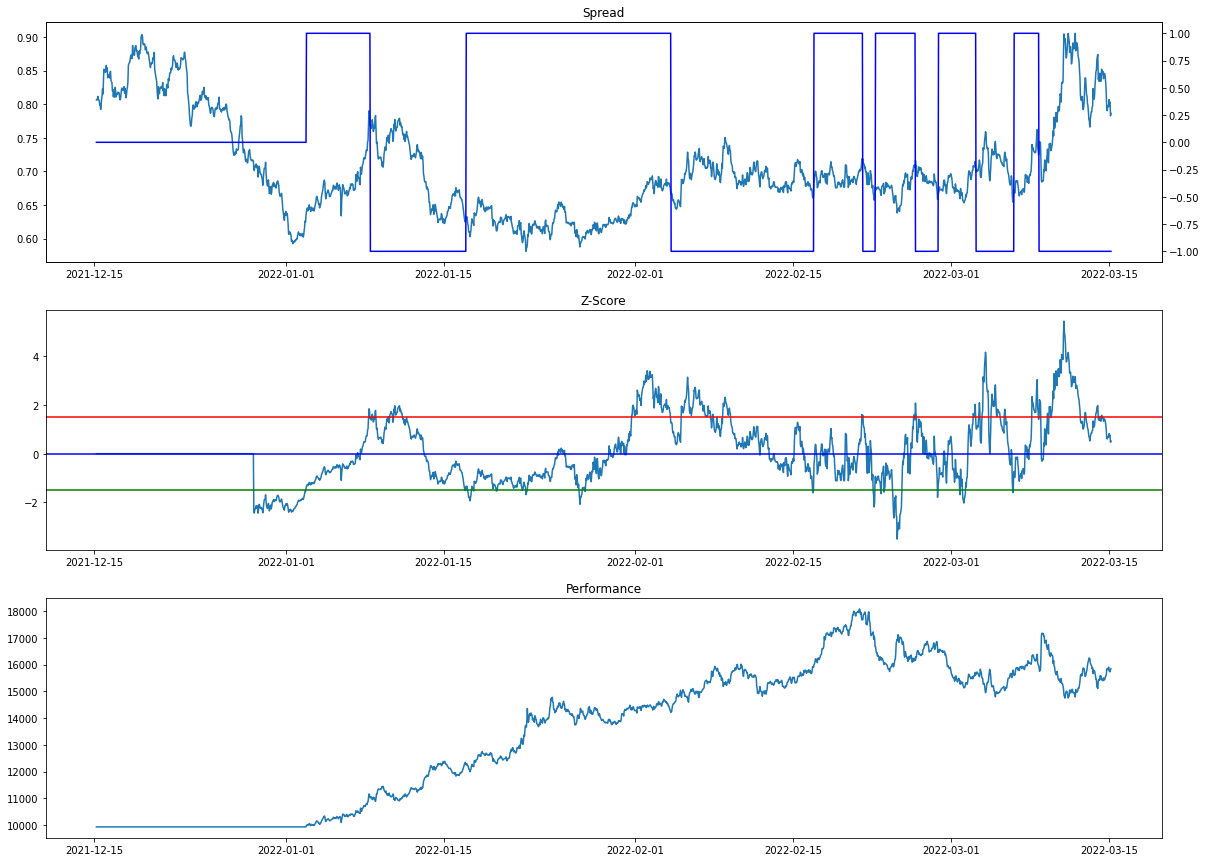

In [383]:
start_date = len(prices[assets[0]]) - 24 * 90
end_date = len(prices[assets[0]]) - 24 * 0
price1 = prices[assets[0]]['price'].reset_index()['price'][start_date:end_date]
price2 = prices[assets[1]]['price'].reset_index()['price'][start_date:end_date]
dates = prices[assets[0]]['date'][start_date:end_date]
fees = 0.0006
rolling_window = 24*14
std_multiple = 1.5
start_capital = 10000.0
order_size_pct = 1
beta = 1
positions, capital, zscore = zscore_mean_reversion_strategy(price1, price2, rolling_window, std_multiple, fees, start_capital, order_size_pct, beta)

# Visualization
fig, axs = plt.subplots(3, figsize=(20,15))
fig.figsize=(20,15)
axs[0].plot(dates, price1/price2)
axs[0].title.set_text('Spread')
axs0_2 = axs[0].twinx()
axs0_2.plot(dates, positions, color='b')
axs[1].plot(dates, zscore)
axs[1].title.set_text('Z-Score')
axs[1].axhline(std_multiple, color='r')
axs[1].axhline(-std_multiple, color='g')
axs[1].axhline(0, color='b')
axs[2].plot(dates, capital)
axs[2].title.set_text('Performance')

print('Returns: {:.2f}%'.format((list(capital)[-1]/list(capital)[0]-1)*100))